# This Notebook is a Multiclassification Pipeline for Text Observations
## The pipeline consists of:  
1. Gathering the data  
1. Processing the data  
1. Exploring the data  
1. Feature engineering  
1. Preliminary feature selection based on univariate proxies  
1. ML models selection  
1. Training chosen model  
1. Generating performance metrics  

## The Data Set:
A data set from [Hackerrank](https://www.hackerrank.com/) that holds texts and a class for each.  
There are 8 total classes for this set, so the appropriate solution is a NLP-ML classifier.

## Approach:
A simple generic ML approach.  
Meaning, I don't leverage any NLP-dedicated models (like BERT or GPT3).  
But rather I design numerical features for the various text terms (One Hot Encoding/Bag of Words/TFIDF), and pipe them into generic ML models.  

Imports:

In [29]:
import numpy as np
import pandas as pd
import matplotlib
import scipy
import re

# ML imports: 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier



Settings:  


In [30]:
# file_name: The file from Hackerrank that holds the raw data
# do_preprocessing: Logical, should preprocessing be performed
# do_feature_eng: Logical
# do_cleaning: Logical
# maximize_a_priori: Logocal, should the univariate preliminary feature selection be based on a priori or a postiori stats
# num_chosen_features_per_class: Int, for the preliminary feature selection, how many features should be selected per class
# test_size: ratio between 0 - 1
# feature_eng_details: Either "TfidfVectorizer" (for TFIDF feature eng.) or "CountVectorizer" (for one hot encoding)
config_dict = {'file_name': "trainingdata_2.txt",
               'do_preprocessing': True,
               'do_feature_eng': True,
               'do_cleaning': True,
               'maximize_a_priori': True,
               'num_chosen_features_per_class': 4,
               'test_size': 0.2,
               'feature_eng_details': "CountVectorizer",
               'ngram_range_min': 1,
               'ngram_range_max': 2,
               'max_features': 2000}

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)


Import data set:  

In [31]:
dataset_raw = pd.read_csv(config_dict["file_name"])

Parse the raw text into 2 columns, class and text:

In [32]:
dataset_parsed = pd.DataFrame([])
dataset_parsed[["class", "text"]] = dataset_raw.iloc[:, 0].str.split(" ", 1, expand=True)

dataset_parsed.head().style.set_properties(**{'text-align': 'left'})

,class,text
0,1,champion products ch approves stock split champion products inc said its board of directors approved a two for one stock split of its common shares for shareholders of record as of april the company also said its board voted to recommend to shareholders at the annual meeting april an increase in the authorized capital stock from five mln to mln shares reuter
1,2,computer terminal systems cpml completes sale computer terminal systems inc said it has completed the sale of shares of its common stock and warrants to acquire an additional one mln shares to sedio n v of lugano switzerland for dlrs the company said the warrants are exercisable for five years at a purchase price of dlrs per share computer terminal said sedio also has the right to buy additional shares and increase its total holdings up to pct of the computer terminal s outstanding common stock under certain circumstances involving change of control at the company the company said if the conditions occur the warrants would be exercisable at a price equal to pct of its common stock s market price at the time not to exceed dlrs per share computer terminal also said it sold the technolgy rights to its dot matrix impact technology including any future improvements to woodco inc of houston tex for dlrs but it said it would continue to be the exclusive worldwide licensee of the technology for woodco the company said the moves were part of its reorganization plan and would help pay current operation costs and ensure product delivery computer terminal makes computer generated labels forms tags and ticket printers and terminals reuter
2,1,cobanco inc cbco year net shr cts vs dlrs net vs assets mln vs mln deposits mln vs mln loans mln vs mln note th qtr not available year includes extraordinary gain from tax carry forward of dlrs or five cts per shr reuter
3,1,am international inc am nd qtr jan oper shr loss two cts vs profit seven cts oper shr profit vs profit revs mln vs mln avg shrs mln vs mln six mths oper shr profit nil vs profit cts oper net profit vs profit revs mln vs mln avg shrs mln vs mln note per shr calculated after payment of preferred dividends results exclude credits of or four cts and or nine cts for qtr and six mths vs or six cts and or cts for prior periods from operating loss carryforwards reuter
4,1,brown forman inc bfd th qtr net shr one dlr vs cts net mln vs mln revs mln vs mln nine mths shr dlrs vs dlrs net mln vs mln revs billion vs mln reuter


Preporcessing:  


In [33]:
def preproc_abstract_and_title(text):
    # All low case:
    text = text.lower()
    # Keep only characters (even upper case in case the previous lower() is cancelled):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    # Unite whitespaces: (https://stackoverflow.com/a/37445349)
    text = re.sub(' +', ' ', text)
    return text
    
dataset_clean = dataset_parsed.copy()
if config_dict["do_cleaning"]:
  dataset_clean["text"] = [preproc_abstract_and_title(text) for text in dataset_clean["text"]]

## Feature engineering:

In [34]:
def feat_eng_text_df(in_df, text_col, labels_col, config_dict):
  if "CountVectorizer" in config_dict["feature_eng_details"]:
    countvectorizer = CountVectorizer(ngram_range=(config_dict["ngram_range_min"], config_dict["ngram_range_max"]), 
                                      stop_words='english',
                                      max_features=config_dict["max_features"],
                                      binary=True)
    out_arr = countvectorizer.fit_transform(in_df[text_col])
    count_tokens = countvectorizer.get_feature_names()
    out_df = pd.DataFrame(data = out_arr.toarray(),columns = count_tokens)
    out_df[labels_col] = in_df[labels_col]

  if "TfidfVectorizer" in config_dict["feature_eng_details"]:
    tfidfvectorizer = TfidfVectorizer(ngram_range=(config_dict["ngram_range_min"], config_dict["ngram_range_max"]), 
                                      stop_words='english',
                                      max_features=config_dict["max_features"])
    out_arr = tfidfvectorizer.fit_transform(in_df[text_col])
    tfidf_tokens = tfidfvectorizer.get_feature_names()
    out_df = pd.DataFrame(data = out_arr.toarray(),columns = tfidf_tokens)
    out_df[labels_col] = in_df[labels_col]
  return out_df


if config_dict["do_feature_eng"]:
  dataset_feat_eng = feat_eng_text_df(dataset_clean, 'text', 'class', config_dict)
else:
  # This option isn't being supported, the notebook would fail down the line:
  dataset_feat_eng = dataset_clean.copy()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Exploring the data:  
1. info()  
1. .describe()  
1. scatter matrix()  

In [35]:
dataset_feat_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5485 entries, 0 to 5484
Columns: 2000 entries, ab to zealand
dtypes: int64(1999), object(1)
memory usage: 83.7+ MB


In [36]:
dataset_feat_eng.head()

,ab,ability,able,abroad,accept,accepted,access,accord,according,account,accounted,accounting,accounts,acquire,acquire pct,acquired,acquired pct,acquires,acquiring,acquisition,acquisition corp,acquisitions,act,action,actions,active,activities,activity,add,added,added reuter,adding,addition,additional,adjusted,adjusted stock,adjustment,administration,advanced,aerospace,...,won,work,workers,working,world,world bank,world oil,worldwide,worth,worth mln,write,writedown,year,year ago,year billion,year company,year earlier,year earnings,year end,year ended,year ending,year includes,year loss,year mln,year net,year oper,year pct,year results,year reuter,year said,year shr,year year,years,yen,yesterday,yeutter,yield,york,yr,zealand
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
dataset_feat_eng.describe()

,ab,ability,able,abroad,accept,accepted,access,accord,according,account,accounted,accounting,accounts,acquire,acquire pct,acquired,acquired pct,acquires,acquiring,acquisition,acquisition corp,acquisitions,act,action,actions,active,activities,activity,add,added,added reuter,adding,addition,additional,adjusted,adjusted stock,adjustment,administration,advanced,aerospace,...,won,work,workers,working,world,world bank,world oil,worldwide,worth,worth mln,write,writedown,year,year ago,year billion,year company,year earlier,year earnings,year end,year ended,year ending,year includes,year loss,year mln,year net,year oper,year pct,year results,year reuter,year said,year shr,year year,years,yen,yesterday,yeutter,yield,york,yr,zealand
count,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,...,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000,5485.000000
mean,0.007293,0.006746,0.010757,0.005469,0.009663,0.006746,0.007657,0.013309,0.020237,0.012944,0.006563,0.012215,0.009845,0.055789,0.005652,0.047037,0.005652,0.010210,0.008204,0.080036,0.005105,0.015132,0.011486,0.028441,0.006381,0.005287,0.011851,0.007293,0.009480,0.062534,0.012215,0.015132,0.018414,0.025160,0.016408,0.006381,0.006016,0.015679,0.004923,0.005105,...,0.005469,0.019143,0.009845,0.011304,0.046490,0.005469,0.006016,0.009298,0.019508,0.006016,0.006563,0.010392,0.359526,0.025342,0.005105,0.009663,0.015861,0.004923,0.015497,0.016226,0.008387,0.005287,0.016591,0.009845,0.052507,0.023336,0.005652,0.005652,0.022789,0.012033,0.080766,0.009845,0.047220,0.014221,0.039198,0.006381,0.005469,0.030629,0.008933,0.006199
std,0.085093,0.081862,0.103164,0.073760,0.097832,0.081862,0.087178,0.114605,0.140823,0.113045,0.080756,0.109855,0.098742,0.229534,0.074972,0.211738,0.074972,0.100535,0.090213,0.271374,0.071272,0.122090,0.106565,0.166245,0.079633,0.072527,0.108223,0.085093,0.096914,0.242145,0.109855,0.122090,0.134455,0.156624,0.127052,0.079633,0.077339,0.124242,0.069994,0.071272,...,0.073760,0.137040,0.098742,0.105725,0.210564,0.073760,0.077339,0.095986,0.138314,0.077339,0.080756,0.101419,0.479905,0.157175,0.071272,0.097832,0.124951,0.069994,0.123529,0.126355,0.091201,0.072527,0.127744,0.098742,0.223067,0.150983,0.074972,0.074972,0.149245,0.109042,0.272500,0.098742,0.212128,0.118410,0.194083,0.079633,0.073760,0.172326,0.094102,0.078495
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [38]:
dataset_feat_eng[["class"]].value_counts().sort_index()

class
1        2840
2        1596
3         251
4         108
5          41
6         253
7         190
8         206
dtype: int64

## Preliminary feature select
This is a univariate feature selection process.  
It is based on conditional dependence between a feature being 0/1 and a class being 1-8.  
Note that the below probabalistc metric relie on the feature engineering being One Hot Encounding.  
If you switch to a differen scheme, then the below aren't the conditional probabilities, but are still proxies for them.  

Calc:  
**P(feature | class)**

In [39]:
## Statistics of features per class:
means_by_class = dataset_feat_eng.groupby(by=["class"]).mean().T.sort_index()
means_by_class.head()

class,1,2,3,4,5,6,7,8
ab,0.003873,0.016291,0.000000,0.000000,0.00000,0.011858,0.000000,0.000000
ability,0.005282,0.007519,0.007968,0.009259,0.00000,0.023715,0.000000,0.004854
able,0.005282,0.011278,0.035857,0.009259,0.04878,0.023715,0.026316,0.014563
abroad,0.002113,0.001880,0.043825,0.018519,0.00000,0.011858,0.015789,0.009709
accept,0.000000,0.020050,0.031873,0.009259,0.02439,0.035573,0.005263,0.004854


Calc:  
**P(class, feature)/(P(class)P(feature)) = P(class | feature)/P(class) = P(feature | class)/P(feature)**

In [40]:
P_class = sorted([[c, np.mean(dataset_feat_eng["class"] == c)] for c in set(means_by_class.columns)])
P_feature = sorted([[f, np.mean(dataset_feat_eng[f] > 0)] for f in dataset_feat_eng.columns if f != "class"])
P_feature_inv = [[f, 1/p] for f, p in P_feature]

P_class_arr = np.array(P_class)
P_feature_inv_arr = np.array(P_feature_inv)
P_class_prod_P_feature_inv_arr = np.outer(P_feature_inv_arr[:, 1].astype(float), P_class_arr[:, 1].astype(float))

P_class_given_feature = means_by_class.copy()
for row_counter in range(len(P_class_given_feature)):
  for c in P_class_given_feature.columns:
    P_class_given_feature[c][row_counter] = means_by_class[c][row_counter] * P_class_prod_P_feature_inv_arr[row_counter, int(c) - 1] / P_class_arr[int(c) - 1, 1].astype(float)

In [41]:
P_class_given_feature.head()

class,1,2,3,4,5,6,7,8
ab,0.531118,2.233866,0.000000,0.000000,0.000000,1.625988,0.000000,0.000000
ability,0.782975,1.114611,1.181221,1.372623,0.000000,3.515650,0.000000,0.719627
able,0.491018,1.048490,3.333446,0.860797,4.534932,2.204730,2.446476,1.353875
abroad,0.386268,0.343672,8.012616,3.385802,0.000000,2.167984,2.886842,1.775081
accept,0.000000,2.074999,3.298504,0.958246,2.524160,3.681483,0.544687,0.502381


For each class, choose the most indicative features:  
**Either maximize the a-priori distribution (Max Liklihood) or statistical dependence (p(A,B)/(P(A)P(B))** 

In [42]:
chosen_features = []
if config_dict["maximize_a_priori"] == True:
  classes = means_by_class.columns
  for c in classes:
    chosen_features += list(means_by_class[c].sort_values(ascending=False).index[:config_dict["num_chosen_features_per_class"]])
else:
  classes = P_class_given_feature.columns
  for c in classes:
    chosen_features += list(P_class_given_feature[c].sort_values(ascending=False).index[:config_dict["num_chosen_features_per_class"]])


chosen_features = list(set(chosen_features))

In [43]:
chosen_features

['bank',
 'trade',
 'dlrs',
 'shipping',
 'market',
 'company',
 'rate',
 'grain',
 'reuter',
 'pct',
 'cts',
 'said',
 'net',
 'oil',
 'port',
 'agriculture',
 'crude',
 'year',
 'vs']

### Leave only chosen features:

In [44]:
dataset_feat_selected = dataset_feat_eng.filter(chosen_features + ["class"])
dataset_feat_selected.head()

,bank,trade,dlrs,shipping,market,company,rate,grain,reuter,pct,cts,said,net,oil,port,agriculture,crude,year,vs,class
0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1
1,0,0,1,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,2
2,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,1
3,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,1
4,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,1


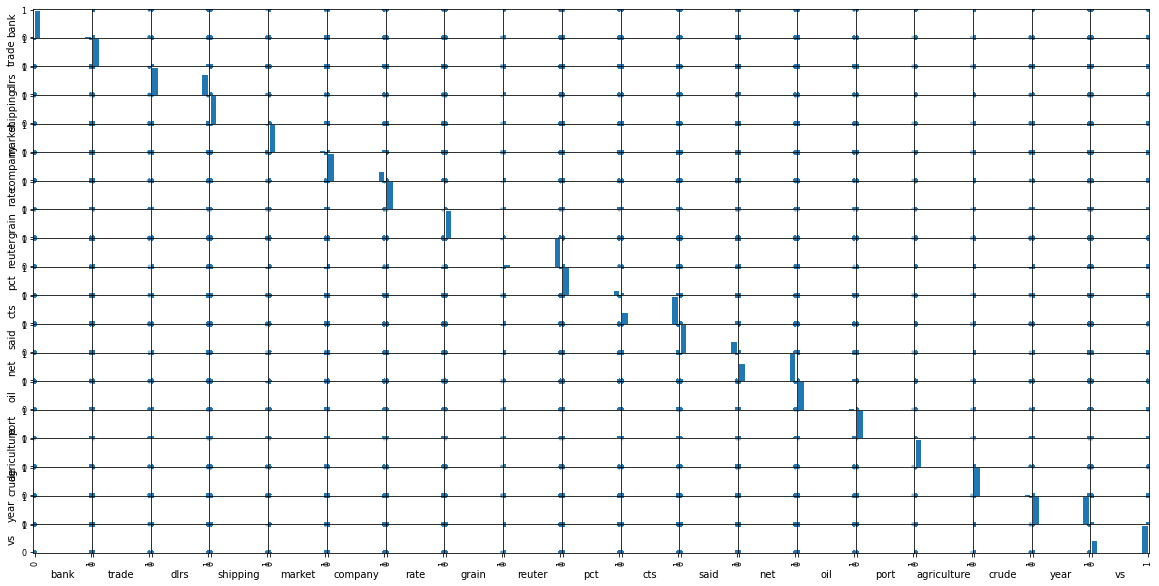

In [45]:
pd.plotting.scatter_matrix(dataset_feat_selected[dataset_feat_selected["class"] == "1"], figsize=(20, 10))
matplotlib.pyplot.show()

Class is 1


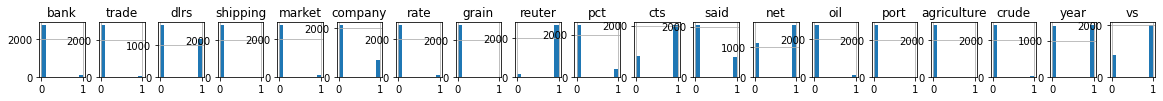

Class is 2


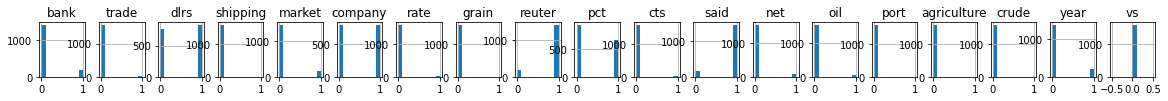

Class is 3


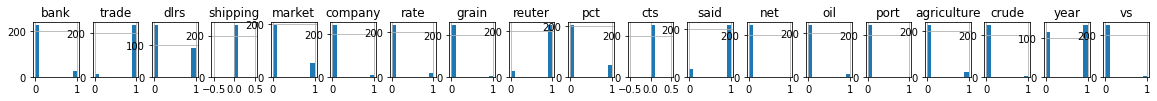

Class is 4


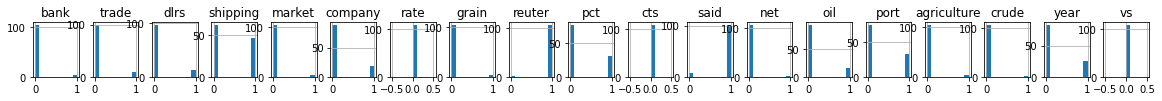

Class is 5


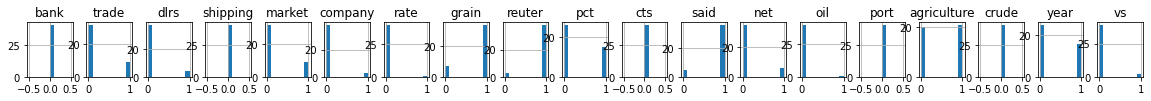

Class is 6


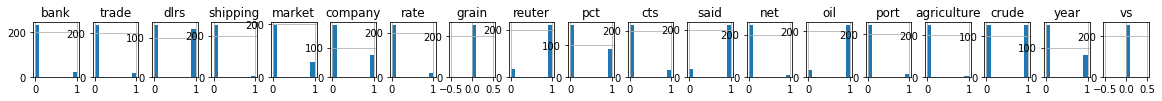

Class is 7


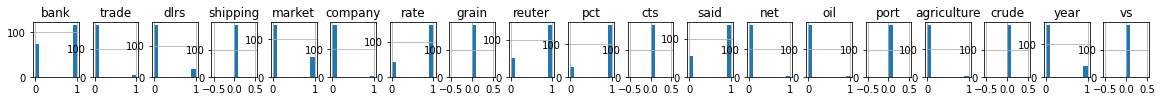

Class is 8


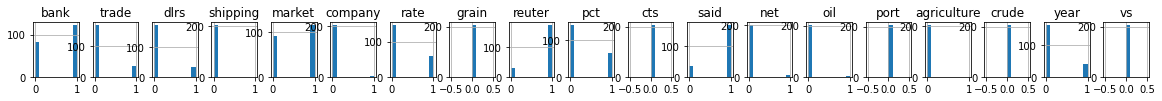

In [46]:
classes = sorted(list(set((dataset_feat_selected["class"]))))
for c in classes:
  print("Class is " + str(c))
  hist = dataset_feat_selected[dataset_feat_selected["class"] == c].hist(figsize=(20, 1), layout=(1, len(dataset_feat_selected.columns) - 1))
  matplotlib.pyplot.show()
  

# ML:

In [47]:
dataset_feat_selected.head()

,bank,trade,dlrs,shipping,market,company,rate,grain,reuter,pct,cts,said,net,oil,port,agriculture,crude,year,vs,class
0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1
1,0,0,1,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,2
2,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,1
3,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,1
4,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,1


**Split to Train/Test**

In [48]:
x_features = dataset_feat_selected.values[:, 0:-1]
y_labels = dataset_feat_selected.values[:, -1]

x_features_train, x_features_test, y_labels_train, y_labels_test = train_test_split(x_features, y_labels, test_size=config_dict["test_size"], random_state=0)

**Iterate over ML models**

In [49]:
models = []
models.append(("LASSO", lm.LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000)))
models.append(("RF", RandomForestClassifier()))
models.append(("NN", MLPClassifier(max_iter=1000)))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("SVM", SVC(gamma='auto')))

results = []
names = []
best_result = 0
for name, model in models:
  kfold = StratifiedKFold()
  cv_results = cross_val_score(model, x_features_train, y_labels_train, scoring='accuracy', cv=kfold)
  results.append(cv_results)
  names.append(name)
  print(name + ": mean(accuracy)=" + str(np.mean(cv_results)) + ", std(accuracy)=" + str(np.std(cv_results)))
  if best_result < np.mean(cv_results):
    best_result = np.mean(cv_results)
    best_model_name = name
    best_model = model
print("Best model is:\n" + best_model_name)

LASSO: mean(accuracy)=0.8495900031947802, std(accuracy)=0.006357414237218703
RF: mean(accuracy)=0.8511850557008647, std(accuracy)=0.004755785223369966
NN: mean(accuracy)=0.854830741578637, std(accuracy)=0.002383594935067954
KNN: mean(accuracy)=0.8265751175964862, std(accuracy)=0.012511538957292064
CART: mean(accuracy)=0.8432064165733774, std(accuracy)=0.006281519719284609
SVM: mean(accuracy)=0.839101773232936, std(accuracy)=0.010747622573274015
Best model is:
NN


**Train the best model:**
Trading off performance with computational resources, I chose Random Forest.  

In [50]:
model = RandomForestClassifier()
params = {"n_estimators": range(10, 31, 3),
          "min_samples_split": range(2, 10, 2)}
grid_search = GridSearchCV(model, params)
grid_search.fit(x_features_train, y_labels_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 31, 3)})

In [51]:
model = RandomForestClassifier(n_estimators=grid_search.best_params_["n_estimators"],
                               min_samples_split=grid_search.best_params_["min_samples_split"],
                               )
model.fit(x_features_train, y_labels_train)

RandomForestClassifier(min_samples_split=8, n_estimators=28)

In [52]:
y_train_estimated = model.predict(x_features_train)
accuracy_train = np.mean(y_train_estimated == y_labels_train)
print("accuracy_train (i.e. fitting score):", round(accuracy_train, 2))

accuracy_train (i.e. fitting score): 0.89


In [53]:
y_test_estimated = model.predict(x_features_test)
accuracy_test = np.mean(y_test_estimated == y_labels_test)
print("accuracy_test:", round(accuracy_test, 2))

accuracy_test: 0.86
